In [1]:
import torch
import torch.nn.functional as F
torch.set_printoptions(precision=None, threshold=None, edgeitems=5, linewidth=120, profile='short', sci_mode=False)

from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.utils.convert import from_networkx
import networkx as nx


/Users/nicibe/miniforge3/envs/pytorch-geometric/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
nx_graph = nx.read_gpickle("data/pickles/nx_road_graph.pickle")
print(nx_graph)

Graph with 7808 nodes and 7964 edges


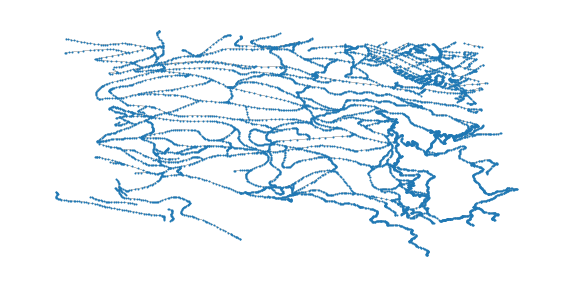

In [3]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(figsize=(10, 5))

nx.draw(
    G=nx_graph,
    pos={n: nx_graph.nodes[n]['coordinates'] for n in nx_graph.nodes},
    ax=ax,
    width=0.25,
    node_size=1,
    with_labels=False
    )

In [4]:
torch_graph = from_networkx(nx_graph) 
torch_graph

/Users/nicibe/miniforge3/envs/pytorch-geometric/lib/python3.10/site-packages/torch_geometric/utils/convert.py:178: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/distiller/project/pytorch/torch/csrc/utils/tensor_new.cpp:210.)
  data[key] = torch.tensor(value)


Data(x=[7808, 7], edge_index=[2, 15928], y=[7808, 2], coordinates=[7808, 2], translation_vectors=[7808, 2], properties=[7808, 9], weight=[15928])

In [5]:
torch_graph.properties[100:110, :]

tensor([[2677565.96, 1247422.59, 999998.00,   100.00,     9.00,   498.27,    29.00,     0.00,     0.00],
        [2677581.36, 1247418.78, 999998.00,   100.00,     9.00,   498.27,    29.00,     0.00,     0.00],
        [2677593.58, 1247417.35, 999998.00,   100.00,     9.00,   498.27,    29.00,     0.00,     0.00],
        [2677605.33, 1247417.98, 999998.00,   100.00,     9.00,   498.27,    29.00,     0.00,     0.00],
        [2677616.60, 1247420.21, 999998.00,   100.00,     9.00,   498.27,    29.00,     0.00,     0.00],
        [2677634.38, 1247425.13, 999998.00,   100.00,     9.00,   498.27,    29.00,     0.00,     0.00],
        [2677648.83, 1247429.57, 999998.00,   100.00,     9.00,   498.27,    29.00,     0.00,     0.00],
        [2677663.91, 1247432.91, 999998.00,   100.00,     9.00,   498.27,    29.00,     0.00,     0.00],
        [2677679.31, 1247434.97, 999998.00,   100.00,     9.00,   498.27,    29.00,     0.00,     0.00],
        [2677698.83, 1247435.93, 999998.00,   100.00,  

In [20]:
torch_graph.properties[torch_graph.properties[:,-1] > 20].shape

torch.Size([30, 9])

In [6]:
torch_graph.x

tensor([[2677934.68, 1245059.11, 999998.00,   100.00,     9.00,   785.41,    71.00],
        [2677935.41, 1245067.05, 999998.00,   100.00,     9.00,   785.41,    71.00],
        [2677936.04, 1245077.53, 999998.00,   100.00,     9.00,   785.41,    71.00],
        [2677936.04, 1245091.34, 999998.00,   100.00,     9.00,   785.41,    71.00],
        [2677935.56, 1245096.58, 999998.00,   100.00,     9.00,   785.41,    71.00],
        ...,
        [2679722.00, 1247145.68, 999998.00,   100.00,     9.00,    88.60,     7.00],
        [2679709.46, 1247127.58, 999998.00,   100.00,     9.00,    88.60,     7.00],
        [2679698.34, 1247110.91, 999998.00,   100.00,     9.00,    88.60,     7.00],
        [2679685.64, 1247092.65, 999998.00,   100.00,     9.00,    88.60,     7.00],
        [2679678.34, 1247082.02, 999998.00,   100.00,     9.00,    88.60,     7.00]], dtype=torch.float64)

In [7]:
print('======================')
print(f'Number of nodes: {torch_graph.num_nodes}')
print(f'Number of edges: {torch_graph.num_edges}')
print(f'Number of node features: {torch_graph.num_node_features}')
print(f'Number of edge features: {torch_graph.num_edge_features}')
print(f'Average node degree: {torch_graph.num_edges / torch_graph.num_nodes:.2f}')
print(f'Contains isolated nodes: {torch_graph.has_isolated_nodes()}')
print(f'Contains self-loops: {torch_graph.has_self_loops()}')
print(f'Is undirected: {torch_graph.is_undirected()}')
print('======================')

Number of nodes: 7808
Number of edges: 15928
Number of node features: 7
Number of edge features: 0
Average node degree: 2.04
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [8]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(in_channels=torch_graph.num_node_features, out_channels=16)
        self.conv2 = GCNConv(in_channels=16, out_channels=2)

    def forward(self, data):
        x, edge_index = data.x.float(), data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return x


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = torch_graph.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss_function = F.mse_loss
epochs = 2000

In [10]:
model.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    out = model(data)
    # print(f"{out=}")
    # print(f"{data.y.shape=}")
    loss = loss_function(out, data.y.float())
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch} of {epochs}", end="\r")

In [27]:
model(torch_graph)

tensor([[nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        ...,
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan]], grad_fn=<AddBackward0>)

In [11]:
model.eval()
pred = model(data)

pred-data.y

tensor([[nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        ...,
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan]], dtype=torch.float64, grad_fn=<SubBackward0>)